In [23]:
import numpy as np
import pandas as pd
from pandas import Grouper 


import seaborn as sns
from sodapy import Socrata

import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import matplotlib.patches as mpatches


from functools import reduce
from datetime import timezone, datetime,date
import pytz


pac = pytz.timezone('America/Los_Angeles')
utc = pytz.timezone('UTC')
%matplotlib inline

In [24]:
def Kel_To_Far(k):
    f = 1.8*(k - 273) + 32
    return f


Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

## Load Bike data and make distribution graphs

In [25]:
#load bike data from Seatlle data API
socrata_domain = 'data.seattle.gov'
socrata_dataset_identifier = '65db-xm6k'
socrata_token  = 'uTBE5rW06JBkufq8UsBellVPy'

client = Socrata(socrata_domain, socrata_token)

results = client.get(socrata_dataset_identifier 
                     ,where= "Date >= '2010-11-01T03:00:00.000' "
                     ,limit = 200000
                    )
fremont = pd.DataFrame.from_records(results)

In [26]:
#Convert date column and set as index
fremont['date'] = pd.to_datetime(fremont.date)
fremont.set_index('date',inplace = True)
fremont.index.names =['Date_Join']

#Convert to numeric columns
fremont['fremont_bridge_nb'] = pd.to_numeric(fremont['fremont_bridge_nb'])
fremont['fremont_bridge_sb'] = pd.to_numeric(fremont['fremont_bridge_sb'])


#Set timezone and sort index
fremont = fremont.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
fremont.sort_index(inplace = True)

#rename
fremont.rename(columns = {'fremont_bridge_nb' : 'EastSide',
                         'fremont_bridge_sb':'WestSide'
                         } , inplace= True)

#FillNA values with mean
fremont['WestSide'].fillna(value = fremont['WestSide'].mean(),inplace = True)
fremont['EastSide'].fillna(value = fremont['EastSide'].mean(),inplace = True)


#calculated Columns
fremont['Mean_Xing'] = fremont[['WestSide','EastSide']].mean(axis=1)
fremont['Total_Xing'] = fremont[['EastSide','WestSide']].sum(axis=1)

fremont['Time_of_Day'] = fremont.index.strftime('%H')
fremont['Month'] = fremont.index.strftime('%m')




print('You have Bridge data from {} to {}'.format(fremont.index.min().strftime('%m/%d/%Y-%I%p'),fremont.index.max().strftime('%m/%d/%Y-%I%p')))
print('There are {} observations and {} columns'.format(fremont.shape[0],fremont.shape[1]))
print(fremont.dtypes)


You have Bridge data from 10/03/2012-12AM to 02/28/2021-11PM
There are 139958 observations and 7 columns
fremont_bridge     object
WestSide          float64
EastSide          float64
Mean_Xing         float64
Total_Xing        float64
Time_of_Day        object
Month              object
dtype: object


In [30]:
#Resample to Daily and create rolling averages
fremont_d = fremont.resample('D').sum()
fremont_d['Month'] = fremont_d.index.strftime('%m')

#3 month Rolling
monthly = fremont.resample('M').sum().rolling(window=3,center=False).mean()
monthly['Month'] = monthly.index.strftime('%m')

#3 Week rolling
weekly = fremont.resample('D').sum().rolling(window=28,center=False).mean()


In [27]:
# weekly= weekly.loc['1/1/2017':'2/1/2021']

C:\anaconda\envs\Data_Science_Capstone\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\anaconda\envs\Data_Science_Capstone\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


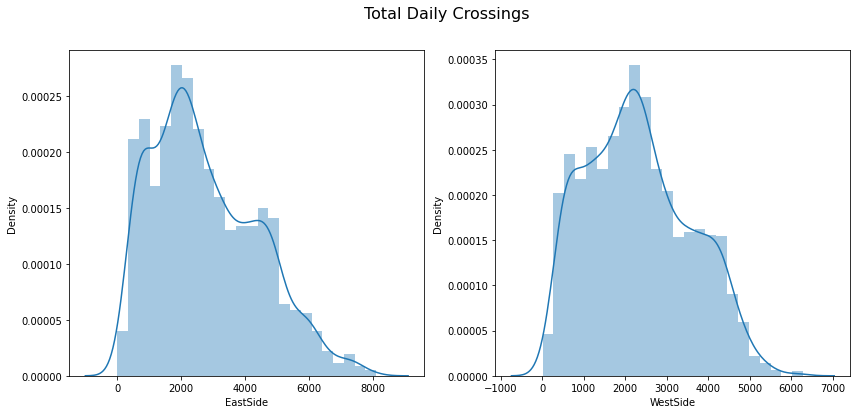

In [28]:
#histogram of bridge crossings
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize = [14,6],)


    sns.distplot(fremont_d['EastSide'],ax=ax1,)
    sns.distplot(fremont_d['WestSide'],ax=ax2,)
    
    
    fig.suptitle('Total Daily Crossings', fontsize=16,color='black')
    ax1.set_xlabel("EastSide", color="black")
    ax2.set_xlabel("WestSide", color="black")
    plt.savefig('./Figures/Daily_Crossing_Hist_{}.png'.format(datetime.now().strftime("%Y%m%d")))
    ;

''

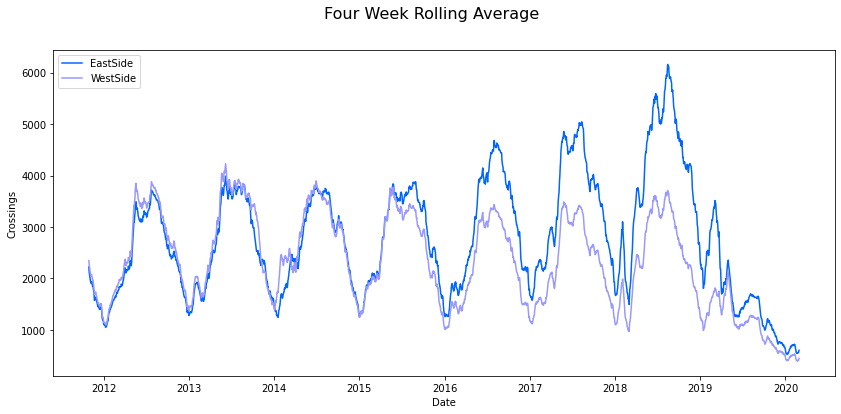

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [14,6],)

sns.lineplot(x=weekly.index, y = 'EastSide',color='#0066ff', data = weekly,ax=ax  )
sns.lineplot(x=weekly.index, y = 'WestSide',color='#9999ff', data = weekly,ax=ax   )

fig.suptitle('Four Week Rolling Average', fontsize=16,color='black')
ax.set_ylabel("Crossings", color="black")
ax.set_xlabel("Date", color="black")
ax.legend(['EastSide','WestSide'],loc="upper left")

plt.savefig('./Figures/Four_Week_Average_{}.png'.format(datetime.now().strftime("%Y%m%d")))

;


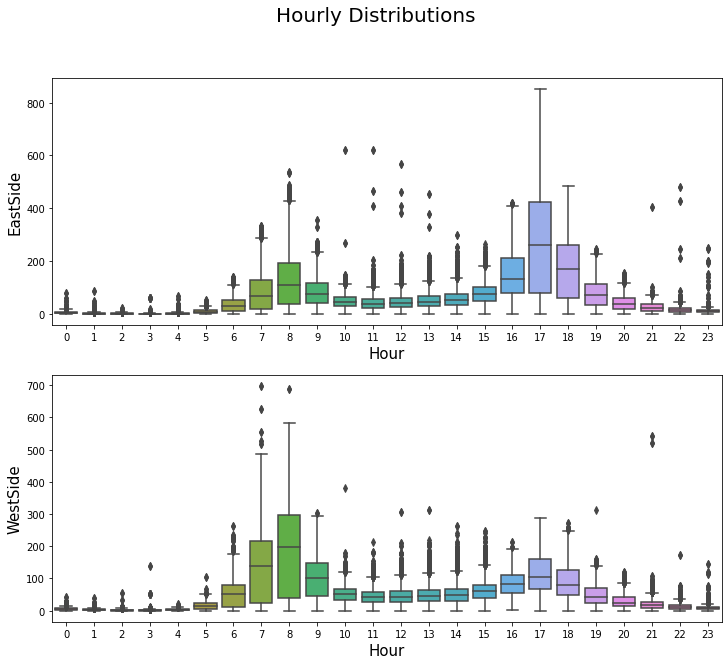

In [32]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, (ax1,ax2) = plt.subplots(nrows= 2, ncols =1 ,figsize=(12,10))
    sns.boxplot(x=fremont.index.hour,y=fremont['EastSide'],data= fremont, ax=ax1)
    sns.boxplot(x=fremont.index.hour,y=fremont['WestSide'],data= fremont, ax=ax2)
    
    fig.suptitle('Hourly Distributions', fontsize=20,color='black')
    ax1.set_xlabel("Hour", color="black",size=15)
    ax2.set_xlabel("Hour", color="black",size=15)
    ax1.set_ylabel("EastSide", color="black",size=15)
    ax2.set_ylabel("WestSide", color="black",size=15)
    plt.savefig('./Figures/Hourly_Box_Plot_{}.png'.format(datetime.now().strftime("%Y%m%d")))

## Load Weather Data

In [34]:
path = "./Data/Daily_Summaries_Merged.csv"
d = ","
wx = pd.read_csv(path,delimiter=d)
wx.DATE = pd.to_datetime(wx.DATE)
wx.rename(columns={'DATE':'Date_Join'},inplace = True)
wx.drop(['LATITUDE','LONGITUDE'],axis = 1,inplace=True)
;

''

In [35]:
wx.loc[wx['STATION'] == 'USW00024233', 'NAME'] = 'SeaTac'
wx.loc[wx['STATION'] == 'USW00024234', 'NAME'] = 'Boeing_Field'
wx.loc[wx['STATION'] == 'US1WAKG0079', 'NAME'] = 'Magnolia'
wx.loc[wx['STATION'] == 'US1WAKG0145', 'NAME'] = 'Phinney'
wx.loc[wx['STATION'] == 'US1WAKG0200', 'NAME'] = 'Georgetown'
wx.loc[wx['STATION'] == 'US1WAKG0199', 'NAME'] = 'GreenWood'
wx.loc[wx['STATION'] == 'US1WAKG0225', 'NAME'] = 'Cap_Hill'
wx.loc[wx['STATION'] == 'US1WAKG0239', 'NAME'] = 'Woodland_Park'

In [36]:
#average WX observations together to get daily totals
wx_d = wx.groupby(by = 'Date_Join')[['PRCP','TMAX','TMIN']].mean()
wx_d = wx_d.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')

#Define Rain Day
wx_d['Rain_Day'] = (wx_d['PRCP'] > .1)
print('You have WX data from {} to {}'.format(wx_d.index.min().strftime('%m/%d/%Y-%I%p'),wx_d.index.max().strftime('%m/%d/%Y-%I%p')))

You have WX data from 10/01/2012-12AM to 03/14/2021-12AM


In [37]:
#Group by and aggregate to get rain day counts
grouped = wx_d.groupby([wx_d.index.month],as_index=True)
result = grouped.agg({"PRCP" :"sum",'TMAX':'mean','Rain_Day':['sum','count']})


df = pd.DataFrame()
df['Total_Days'] =result.Rain_Day['count']
df['Rain_Days'] =result.Rain_Day['sum']
df['TMAX'] = result.TMAX
df['Clear_Days'] =result.Rain_Day['count'] - result.Rain_Day['sum']

C:\anaconda\envs\Data_Science_Capstone\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout, = ax.plot([], [], **kws)
C:\anaconda\envs\Data_Science_Capstone\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line, = ax.plot([], [], **kws)
C:\anaconda\envs\Data_Science_Capstone\lib\site-packages\seaborn\relational.py:529: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line, = ax.plot(x, y, **kws)


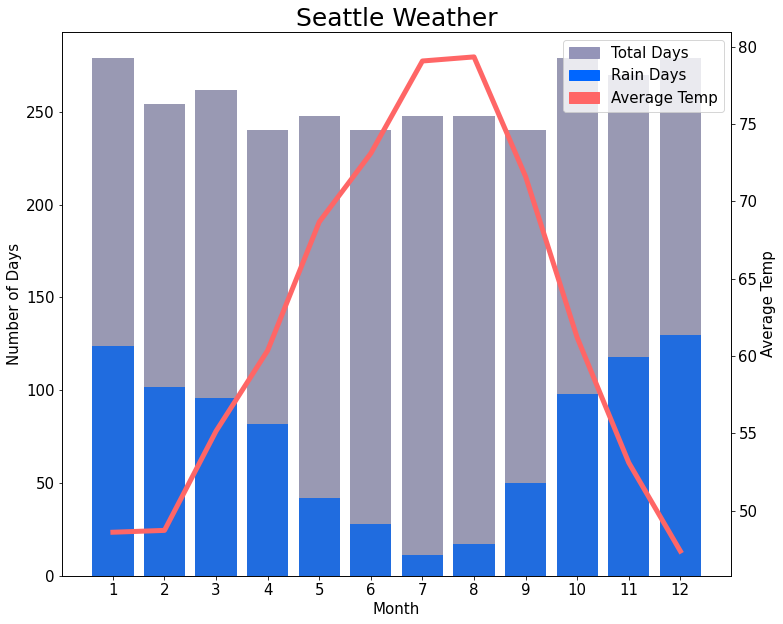

In [38]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black','font.size' : '15'}):
    fig, ax = plt.subplots(1,1, figsize=(12,10))
    sns.barplot(x=df.index, y="Total_Days",data=df,color='#9494b8')
    sns.barplot(x=df.index, y="Rain_Days",data=df,color='#0066ff')

    ax2 = ax.twinx()

    sns.lineplot(x=df.index-1 , y="TMAX",data=df,color='#ff6666', ax=ax2, LW = 5)

    ax.set_xlabel("Month", color="black",size=15)
    ax2.set_ylabel("Average Temp", color="black",size=15)
    ax.set_ylabel('Number of Days', color="black",size=15)
    ax.set_title('Seattle Weather',color='black',size=25)
    
    total = mpatches.Patch(color='#9494b8', label='Total Days')
    rain = mpatches.Patch(color='#0066ff', label='Rain Days')
    temp = mpatches.Patch(color='#ff6666', label='Average Temp')
    
    plt.legend(handles=[total,rain,temp])
    plt.savefig('./Figures/SEA_WX_{}.png'.format(datetime.now().strftime("%Y%m%d")))

In [39]:
#Merge WX and Fremont
data = fremont_d.merge(wx_d, how = 'inner',left_on = 'Date_Join',right_on = 'Date_Join')
print('You have combined data from {} to {}'.format(fremont.index.min().strftime('%m/%d/%Y-%I%p'),fremont.index.max().strftime('%m/%d/%Y-%I%p')))

#data.head()

You have combined data from 10/03/2012-12AM to 02/28/2021-11PM


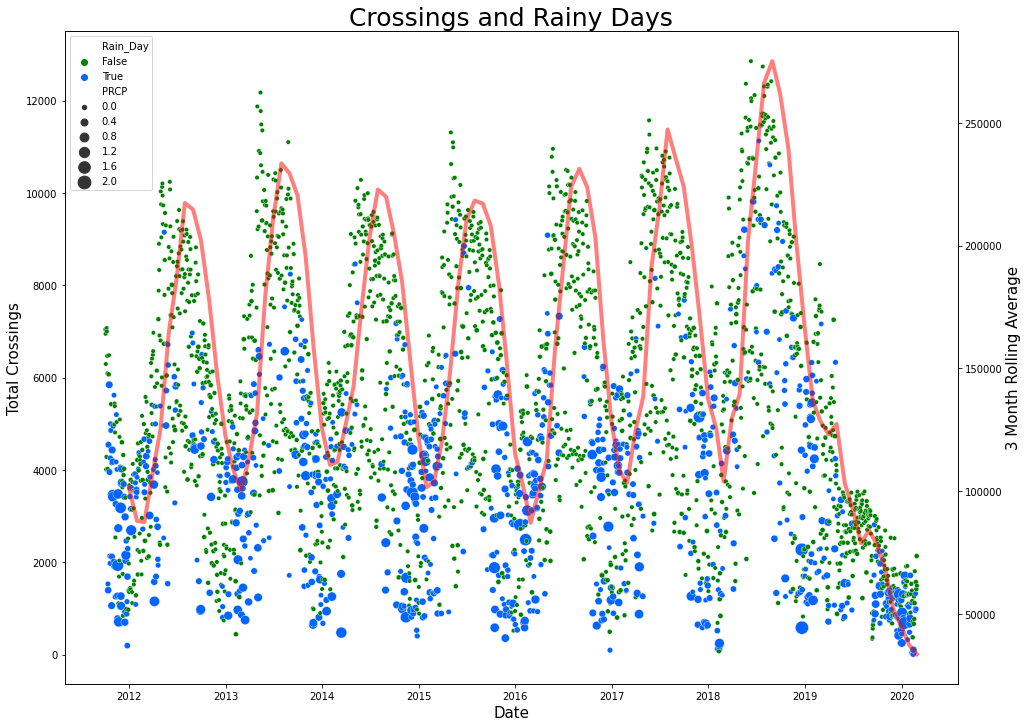

In [47]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, ax = pyplot.subplots(figsize=(16,12))

    sns.scatterplot(x=data.index, 
                    y="Total_Xing", 
                    data=data,
                    size='PRCP',
                    sizes=(20, 175),
                    hue='Rain_Day',
                    legend='brief',    
                    palette=['#008000','#0066ff'],
                    ax = ax
                         )

#     ax.set_xlim('10/3/2012', '2/28/2021')
#     ax.set_ylim(0, 6500)
    ax.set_xlabel("Date", color="black",size=15)
    ax.set_ylabel('Total Crossings', color="black",size=15)
    ax.set_title('Crossings and Rainy Days',color='black',size=25)
    ax.legend(loc='upper left')
   
    
    ax2 = ax.twinx()
    sns.lineplot(x=monthly.index, y = 'Total_Xing', data = monthly,ax=ax2,color='#ff0000',alpha=.5,lw = 4)
    ax2.set_ylabel('3 Month Rolling Average', color="black",size=15)
    plt.savefig('./Figures/Crossing_Rain_Scatter_total_{}.png'.format(datetime.now().strftime("%Y%m%d")))
    ;

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\seaborn\relational.py:915: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1260: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\seaborn\relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64

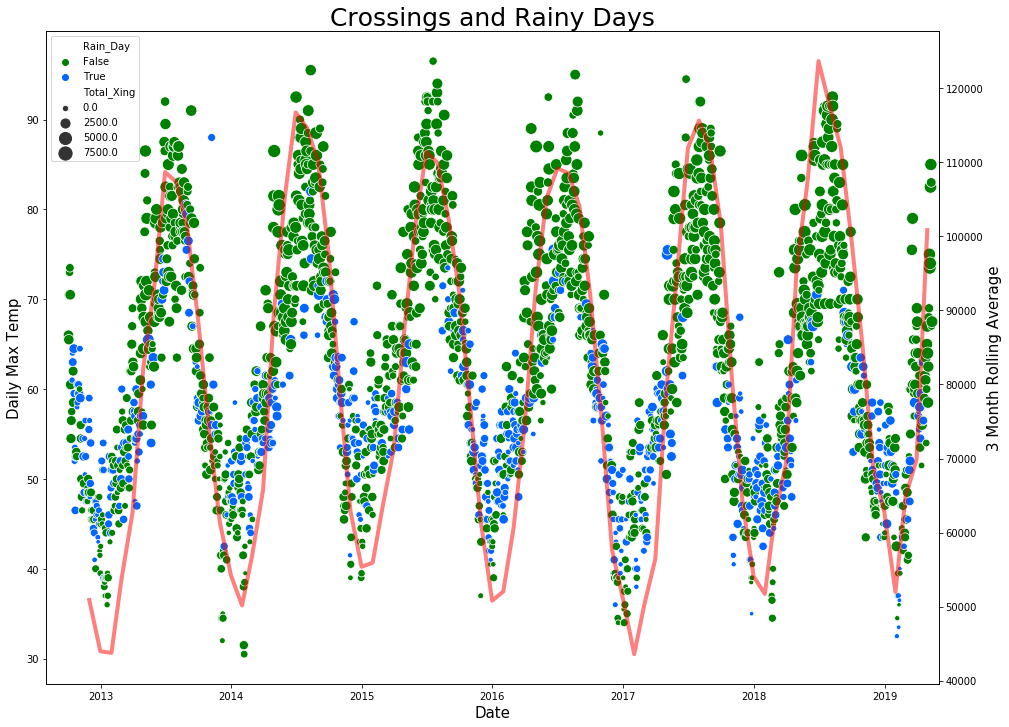

In [16]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, ax = pyplot.subplots(figsize=(16,12))

    sns.scatterplot(x=data.index, 
                    y="TMAX", 
                    data=data,
                    size='Total_Xing',
                    sizes=(20, 175),
                    hue='Rain_Day',
                    legend='brief',    
                    palette=['#008000','#0066ff'],
                    ax = ax
                         )

    ax.set_xlim('8/1/2012', '6/1/2019')
    #ax.set_ylim(0, 100)
    ax.set_xlabel("Date", color="black",size=15)
    ax.set_ylabel('Daily Max Temp', color="black",size=15)
    ax.set_title('Crossings and Rainy Days',color='black',size=25)
    ax.legend(loc='upper left')
    
   
    
    ax2 = ax.twinx()
    sns.lineplot(x=monthly.index-1, y = 'Total_Xing', data = monthly,ax=ax2,color='#ff0000',alpha=.5,lw = 4)
    ax2.set_ylabel('3 Month Rolling Average', color="black",size=15)
    plt.savefig('./Figures/Crossing_Rain_Scatter_Temp.png')
    ;

## Load Hourly WX data

In [17]:
#load Weather Data
path = './Data/OpenWeatherMap/OpenWeatherMap_Seattle_Bulk.csv'
wx_hourly = pd.read_csv(path)

#format date column and set as index. Convert to Pacifict time. Original data in UTC
wx_hourly['dt_iso']=pd.to_datetime(wx_hourly['dt_iso'], format = '%Y-%m-%d %H:%M:%S +%f %Z' )
wx_hourly = wx_hourly.set_index('dt_iso')
wx_hourly = wx_hourly.tz_convert(pac)
wx_hourly.index.names =['Date_Join']


#convert temps from Kelving to Farenheit
wx_hourly['temp_f'] = wx_hourly.temp.apply(Kel_To_Far)
wx_hourly['temp_min_f'] = wx_hourly.temp_min.apply(Kel_To_Far)
wx_hourly['temp_max_f'] = wx_hourly.temp_max.apply(Kel_To_Far)



#drop unused column and re-order logically
wx_hourly.drop(['lat','lon','city_id','city_name','temp','temp_min','temp_max','sea_level','grnd_level','dt','weather_icon'],axis = 1,inplace=True)
wx_hourly.drop(['rain_3h','snow_3h','rain_24h','snow_24h','rain_today','snow_today'],axis = 1,inplace=True)
wx_hourly.drop(['weather_main','weather_id'],axis = 1,inplace=True)
 
neworder =['temp_f','temp_min_f','temp_max_f','pressure', 'humidity', 'wind_speed', 'wind_deg',
            'rain_1h','snow_1h', #'rain_3h','snow_3h','rain_24h','snow_24h', 'rain_today','snow_today',
            'clouds_all','weather_description'#, 'weather_main','weather_id'
          ]
wx_hourly=wx_hourly.reindex(columns=neworder)


#fill NA data with 0
wx_hourly['rain_1h'].fillna(value = 0,inplace = True)
wx_hourly['snow_1h'].fillna(value = 0,inplace =True)

#Calculated Columns
wx_hourly['Time_of_Day'] = wx_hourly.index.strftime('%H')
wx_hourly['Month'] = wx_hourly.index.strftime('%m')
wx_hourly['WeekDay'] = wx_hourly.index.strftime('%A')
wx_hourly['Season'] = wx_hourly.index.to_series().apply(get_season)

#Dummy Columns
#wx_hourly = pd.get_dummies(data=wx_hourly,columns = ['weather_description','Season','Time_of_Day','Month','WeekDay'])


#wx_hourly.head(5)
print('You have Weather data from {} to {}'.format(wx_hourly.index.min().strftime('%m/%d/%Y-%I%p'),wx_hourly.index.max().strftime('%m/%d/%Y-%I%p')))
print('There are {} observations and {} columns'.format(wx_hourly.shape[0],wx_hourly.shape[1]))
#print(wx_hourly.dtypes)

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.


You have Weather data from 10/01/2012-06AM to 06/13/2019-05PM
There are 56675 observations and 15 columns


In [18]:
description_plot = pd.DataFrame(wx_hourly['weather_description'].value_counts(normalize=True))
#description_plot.reset_index(inplace=True)


''

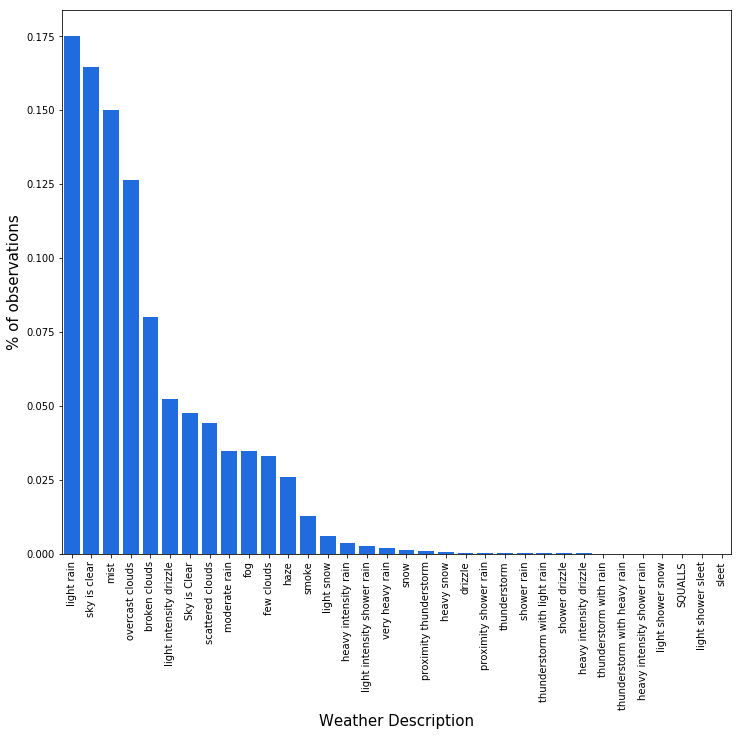

In [19]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
sns.barplot(x=description_plot.index, y="weather_description",data=description_plot,color='#0066ff',ax=ax)
plt.xticks(rotation=90)
ax.set_xlabel("Weather Description", color="black",size=15)
ax.set_ylabel('% of observations', color="black",size=15)

plt.savefig('./Figures/WX_Description.png')
;

## Examine individual Days

In [20]:
#what is the rainiest day of the year
grouped = wx_d.groupby([wx_d.index.month,wx_d.index.day],as_index=True)
result = grouped.agg({"PRCP" :['sum','mean']})
result.sort_values(by=('PRCP','sum'),ascending=False).head(15)

PRCP          
                          sum      mean
Date_Join Date_Join                    
11        23         4.552000  0.505778
1         18         4.400417  0.440042
10        31         3.800000  0.422222
12        12         3.699714  0.411079
3         15         3.601310  0.360131
11        22         3.566667  0.396296
12        9          3.338548  0.370950
          19         3.151071  0.350119
3         10         3.117833  0.311783
          14         3.069167  0.306917
11        1          3.051500  0.339056
          15         3.043750  0.338194
1         9          2.981000  0.298100
2         12         2.978833  0.297883
1         12         2.876667  0.287667

In [45]:
rain = data.loc[(data.index.month==11)&(data.index.day==23)]
rain['WeekDay'] = rain.index.strftime('%A')
rain.sort_values(by='PRCP',ascending=False)

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,EastSide,WestSide,Mean_Xing,Total_Xing,Month,PRCP,TMAX,TMIN,Rain_Day,WeekDay
Date_Join,,,,,,,,,,
2012-11-23 00:00:00-08:00,187.0,168.0,177.5,355.0,11,1.130000,50.0,43.5,True,Friday
2018-11-23 00:00:00-08:00,331.0,268.0,299.5,599.0,11,0.582000,50.5,42.0,True,Friday
2016-11-23 00:00:00-08:00,1014.0,780.0,897.0,1794.0,11,0.533333,48.5,42.5,True,Wednesday
2014-11-23 00:00:00-08:00,362.0,425.0,393.5,787.0,11,0.426667,56.0,43.0,True,Sunday
2017-11-23 00:00:00-08:00,202.0,168.0,185.0,370.0,11,0.338333,59.5,48.5,True,Thursday
2015-11-23 00:00:00-08:00,1182.0,1096.0,1139.0,2278.0,11,0.040000,45.5,32.5,False,Monday
2013-11-23 00:00:00-08:00,524.0,686.0,605.0,1210.0,11,0.020000,52.0,31.5,False,Saturday


In [46]:
rain.describe()

,EastSide,WestSide,Mean_Xing,Total_Xing,PRCP,TMAX,TMIN
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,543.142857,513.000000,528.071429,1056.142857,0.438619,51.714286,40.500000
std,398.171834,352.828098,371.082362,742.164723,0.376801,4.698024,6.198118
min,187.000000,168.000000,177.500000,355.000000,0.020000,45.500000,31.500000
25%,266.500000,218.000000,242.250000,484.500000,0.189167,49.250000,37.250000
50%,362.000000,425.000000,393.500000,787.000000,0.426667,50.500000,42.500000
75%,769.000000,733.000000,751.000000,1502.000000,0.557667,54.000000,43.250000
max,1182.000000,1096.000000,1139.000000,2278.000000,1.130000,59.500000,48.500000
